In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
import scipy
%matplotlib inline

X, y = make_classification(n_samples=30000, n_features=10, n_redundant=3, n_repeated=2, 
                           n_informative=5, n_clusters_per_class=4, 
                           random_state=42) #for reproducibility 

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [4]:
def dist(x,y):
    return np.linalg.norm(x-y)
    #return scipy.spatial.distance.correlation(x,y)

def poprow(arr,i):
    pop = arr[i]
    new_array = np.vstack((arr[:i],arr[i+1:]))
    return new_array,pop

def cluster(X, p, k):
    c = [p]
    D = np.column_stack((X,[dist(v[:-1],p[:-1]) for v in X]))
    D = D[D[:,-1].argsort()]
    D = np.delete(D, -1, 1)
    c.extend(D[:k-1])
    D = D[k-1:]
    
    xc = np.array([p[:-1] for p in c], copy=False, ndmin=2)
    yc = np.array([p[-1] for p in c], copy=False)
    cl = (xc, yc)
    return D, cl
    
def mdav(X, y, k):
    D = np.column_stack((X,y))
    clusters = []
    while len(D) >= 3*k:
        # Centroid
        xm = np.mean(D, axis=0)
        # Furthest from centroid
        xri = np.argmax([dist(v[:-1],xm[:-1]) for v in D])
        D, xr = poprow(D, xri)
        # Furthest from furthest from centroid
        xsi = np.argmax([dist(v[:-1],xr[:-1]) for v in D])
        D, xs = poprow(D, xsi) 

        #cluster of xr
        D, c = cluster(D, xr, k)
        clusters.append(c)
        #cluster of xs
        D, c = cluster(D, xs, k)
        clusters.append(c)
        
    if len(D) >= 2*k and len(D) < 3*k:
        # Centroid
        xm = np.mean(D, axis=0)
        # Furthest from centroid
        xri = np.argmax([dist(v[:-1],xm[:-1]) for v in D])
        D, xr = poprow(D, xri)
        #cluster of xr
        D, c = cluster(D, xr, k)
        clusters.append(c)
        
        # rest of points
        xc = np.array([p[:-1] for p in D[:]], copy=False, ndmin=2)
        yc = np.array([p[-1] for p in D[:]], copy=False)
        cl = (xc, yc)
        clusters.append(cl)     
    else:
        # rest of points
        xc = np.array([p[:-1] for p in D[:]], copy=False, ndmin=2)
        yc = np.array([p[-1] for p in D[:]], copy=False)
        cl = (xc, yc)
        clusters.append(cl)
    
    centroids = np.array([np.mean(c[0],axis=0) for c in clusters], copy=False)
    
    return clusters, centroids

from sklearn import tree
def gen_explanations(clustering, max_depth=-1):
    explanations = []
    for cluster in clustering:
        # Testing with max depth
        if max_depth < 1:
            exp = tree.DecisionTreeClassifier()
        else:
            exp = tree.DecisionTreeClassifier(max_depth=max_depth)
        exp.fit(cluster[0],cluster[1])
        explanations.append(exp) 
    return explanations

def pre_explanations(explanations, centroids, X):
    predictions = []
    for sample in X:
        #select the closest classifier
        exp = explanations[np.argmin([dist(sample,c) for c in centroids])]
        exp_pred = exp.predict([sample])
        predictions.append(int(exp_pred[0]))
    return predictions

def pre_explanations_ext(explanations, centroids, X, T, n):
    predictions = []
    for sample, truth in zip(X,T):
        #select the n closest classifiers
        mins = np.array([dist(sample,c) for c in centroids]).argsort()[:n]
        for m in mins:
            exp = explanations[m]
            exp_pred = exp.predict([sample])
            if(int(exp_pred[0]) == truth):
                break
        predictions.append(int(exp_pred[0]))
    return predictions

In [5]:
# Generate clusters for different representativities
representativity = [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
K = [int(len(X_train)*r) for r in representativity]
clusterings = []
centroids_of_clusterings = []
for k in K:
    clustering, centroids = mdav(X_train, y_train, k)
    clusterings.append(clustering)
    centroids_of_clusterings.append(centroids)    

In [6]:
# Train explanations of unlimited max_depth
clu_explanations = []
for clustering in clusterings:
    # Test with shallow trees depht=4
    explanations = gen_explanations(clustering, 4)
    clu_explanations.append(explanations)

In [7]:
# Train blackbox model
from sklearn.neural_network import MLPClassifier
blackbox = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001,
                     solver='sgd', verbose=10,  random_state=21,tol=0.000000001)
blackbox.fit(X_train, y_train)

Iteration 1, loss = 0.62987806
Iteration 2, loss = 0.49942627
Iteration 3, loss = 0.42931253
Iteration 4, loss = 0.38915404
Iteration 5, loss = 0.36430560
Iteration 6, loss = 0.34729189
Iteration 7, loss = 0.33321445
Iteration 8, loss = 0.32123528
Iteration 9, loss = 0.31074235
Iteration 10, loss = 0.30157711
Iteration 11, loss = 0.29292598
Iteration 12, loss = 0.28512049
Iteration 13, loss = 0.27796100
Iteration 14, loss = 0.27150803
Iteration 15, loss = 0.26519194
Iteration 16, loss = 0.25983823
Iteration 17, loss = 0.25454223
Iteration 18, loss = 0.24990616
Iteration 19, loss = 0.24546262
Iteration 20, loss = 0.24124059
Iteration 21, loss = 0.23747795
Iteration 22, loss = 0.23404035
Iteration 23, loss = 0.23097437
Iteration 24, loss = 0.22804702
Iteration 25, loss = 0.22530472
Iteration 26, loss = 0.22287647
Iteration 27, loss = 0.22043006
Iteration 28, loss = 0.21825096
Iteration 29, loss = 0.21613716
Iteration 30, loss = 0.21443536
Iteration 31, loss = 0.21245511
Iteration 32, los

Iteration 253, loss = 0.13453330
Iteration 254, loss = 0.13462955
Iteration 255, loss = 0.13464599
Iteration 256, loss = 0.13421554
Iteration 257, loss = 0.13403264
Iteration 258, loss = 0.13352516
Iteration 259, loss = 0.13370270
Iteration 260, loss = 0.13372393
Iteration 261, loss = 0.13425111
Iteration 262, loss = 0.13437788
Iteration 263, loss = 0.13393820
Iteration 264, loss = 0.13357098
Iteration 265, loss = 0.13351799
Iteration 266, loss = 0.13337713
Iteration 267, loss = 0.13310190
Iteration 268, loss = 0.13339428
Iteration 269, loss = 0.13313787
Iteration 270, loss = 0.13328890
Iteration 271, loss = 0.13345985
Iteration 272, loss = 0.13202180
Iteration 273, loss = 0.13204142
Iteration 274, loss = 0.13264477
Iteration 275, loss = 0.13225598
Iteration 276, loss = 0.13195169
Iteration 277, loss = 0.13163046
Iteration 278, loss = 0.13207696
Iteration 279, loss = 0.13160952
Iteration 280, loss = 0.13132939
Iteration 281, loss = 0.13151756
Iteration 282, loss = 0.13143003
Iteration 

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100, 100), learning_rate='constant',
              learning_rate_init=0.001, max_iter=500, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=21, shuffle=True, solver='sgd', tol=1e-09,
              validation_fraction=0.1, verbose=10, warm_start=False)

In [16]:
#Train big tree
surrogate = tree.DecisionTreeClassifier()
surrogate.fit(X_train,y_train)
display(surrogate.score(X_test, y_test))
display(surrogate.tree_.node_count)

0.8870707070707071

2943

In [17]:
truth = y_test
blackbox_predictions = blackbox.predict(X_test)
surrogate_predictions = surrogate.predict(X_test)
explanation_predictions = []
explanation_ext_predictions = []
for i in range(len(clu_explanations)):
    p = pre_explanations(clu_explanations[i], centroids_of_clusterings[i], X_test)
    q = pre_explanations_ext(clu_explanations[i], centroids_of_clusterings[i], X_test, blackbox_predictions, 3)
    explanation_predictions.append(p)
    explanation_ext_predictions.append(q)

In [18]:
# acc = TP+TN/all
acc_blackbox = np.mean([t==p for t,p in zip(truth, blackbox_predictions)])
acc_surrogate = np.mean([t==p for t,p in zip(truth, surrogate_predictions)])
acc_explanations = []
for i in range(len(explanation_predictions)):
    acc_explanations.append(np.mean([t==p for t,p in zip(truth, explanation_predictions[i])]))
    
acc_explanations_ext = []
for i in range(len(explanation_ext_predictions)):
    acc_explanations_ext.append(np.mean([t==p for t,p in zip(truth, explanation_ext_predictions[i])]))

acc_cross = []
for i in range(len(explanation_predictions)):
    acc_cross.append(np.mean([t==p for t,p in zip(blackbox_predictions, explanation_predictions[i])]))

acc_cross_ext = []
for i in range(len(explanation_predictions)):
    acc_cross_ext.append(np.mean([t==p for t,p in zip(blackbox_predictions, explanation_ext_predictions[i])]))

display(acc_blackbox)
display(acc_surrogate)
display(acc_explanations)
display(acc_explanations_ext)
display(acc_cross)
display(acc_cross_ext)

0.9422222222222222

0.8870707070707071

[0.8947474747474747,
 0.8862626262626263,
 0.888080808080808,
 0.8854545454545455,
 0.8743434343434343,
 0.8761616161616161,
 0.8666666666666667,
 0.8742424242424243,
 0.8498989898989899,
 0.8394949494949495,
 0.8332323232323232,
 0.8396969696969697,
 0.8461616161616161]

[0.9394949494949495,
 0.9386868686868687,
 0.936969696969697,
 0.935959595959596,
 0.935050505050505,
 0.927070707070707,
 0.9221212121212121,
 0.923030303030303,
 0.9111111111111111,
 0.9024242424242425,
 0.9014141414141414,
 0.8992929292929293,
 0.8901010101010101]

[0.9105050505050505,
 0.9016161616161616,
 0.9056565656565656,
 0.9058585858585858,
 0.8901010101010101,
 0.8923232323232323,
 0.8826262626262626,
 0.8867676767676768,
 0.861010101010101,
 0.8502020202020202,
 0.8447474747474748,
 0.848989898989899,
 0.8554545454545455]

[0.9853535353535353,
 0.9857575757575757,
 0.9844444444444445,
 0.9785858585858586,
 0.980909090909091,
 0.9707070707070707,
 0.9635353535353536,
 0.9581818181818181,
 0.9515151515151515,
 0.9381818181818182,
 0.9361616161616162,
 0.9326262626262626,
 0.9181818181818182]

In [11]:
min_nodes = []
max_nodes = []
mean_nodes = []
median_nodes = []
n_counts = []
for explanations in clu_explanations:
    node_counts = [exp.tree_.node_count for exp in explanations]
    n_counts.append(node_counts)
    min_nodes.append(np.min(node_counts))
    max_nodes.append(np.max(node_counts))
    mean_nodes.append(np.mean(node_counts))
    median_nodes.append(np.median(node_counts))

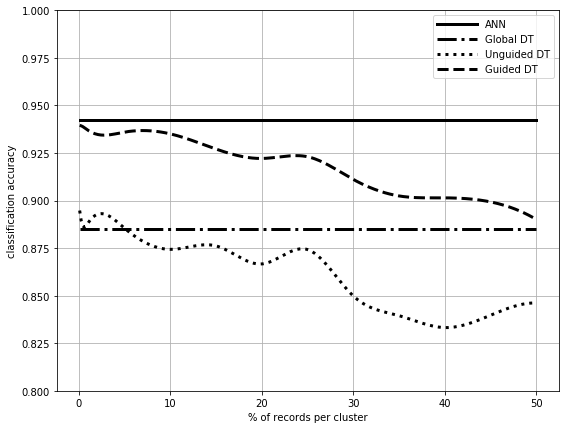

In [12]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline

representativity = [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
representativity = list([r*100 for r in representativity])

xnew = np.linspace(min(representativity),max(representativity),300)
spl = make_interp_spline(representativity, acc_explanations, k=3) #BSpline object
ynew = spl(xnew)

spl = make_interp_spline(representativity, acc_explanations_ext, k=3) #BSpline object
ynew4 = spl(xnew)

acc_blackbox_const = [acc_blackbox]*len(representativity)
spl = make_interp_spline(representativity, acc_blackbox_const, k=3) #BSpline object
ynew2 = spl(xnew)

big_tree = [acc_surrogate]*len(representativity)
spl = make_interp_spline(representativity, big_tree, k=3) #BSpline object
ynew6 = spl(xnew)

spl = make_interp_spline(representativity, acc_cross, k=3) #BSpline object
ynew3 = spl(xnew)

spl = make_interp_spline(representativity, acc_cross_ext, k=3) #BSpline object
ynew5 = spl(xnew)

plt.figure(figsize=(9,7))
plt.plot(xnew,ynew2,linestyle='-',linewidth=3,color='k',label='ANN')
plt.plot(xnew,ynew6,linestyle='-.',linewidth=3,color='k',label='Global DT')
plt.plot(xnew,ynew,linestyle=':',linewidth=3,color='k',label='Unguided DT')
#plt.plot(xnew,ynew3, label='interpretable w.r.t. blackbox')
plt.plot(xnew,ynew4,linestyle='--',linewidth=3,color='k',label='Guided DT')

#plt.plot(xnew,ynew5, label='interpretable-guided w.r.t. blackbox')


plt.legend(handlelength=4)
plt.ylim(0.8,1)
plt.xlabel('% of records per cluster')
plt.ylabel('classification accuracy')
plt.grid()
plt.show()
plt.close()

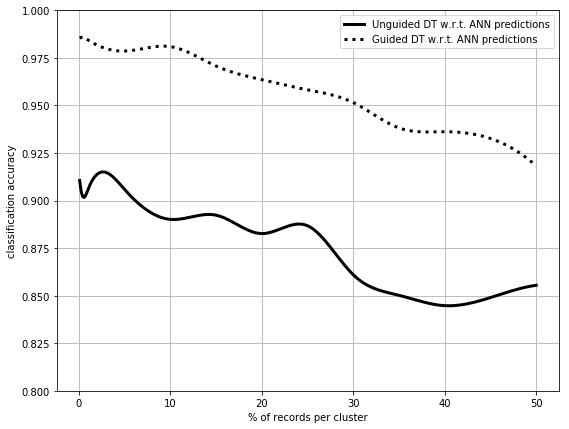

In [13]:
plt.figure(figsize=(9,7))
##plt.plot(xnew,ynew2, label='blackbox')
##plt.plot(xnew,ynew, label='interpretable')
plt.plot(xnew,ynew3,linestyle='-',linewidth=3,color='k',label='Unguided DT w.r.t. ANN predictions')
##plt.plot(xnew,ynew4, label='interpretable-guided')
plt.plot(xnew,ynew5,linestyle=':',linewidth=3,color='k',label='Guided DT w.r.t. ANN predictions')

plt.legend()
plt.ylim(0.8,1)
plt.xlabel('% of records per cluster')
plt.ylabel('classification accuracy')
plt.grid()
plt.show()
plt.close()

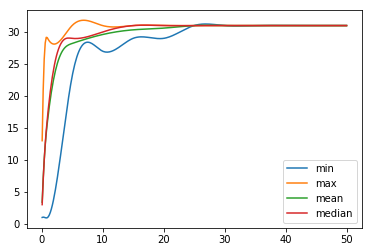

In [14]:
plt.plot(xnew,make_interp_spline(representativity, min_nodes, k=3)(xnew),label='min')
plt.plot(xnew,make_interp_spline(representativity, max_nodes, k=3)(xnew),label='max')
plt.plot(xnew,make_interp_spline(representativity, mean_nodes, k=3)(xnew),label='mean')
plt.plot(xnew,make_interp_spline(representativity, median_nodes, k=3)(xnew),label='median')
plt.legend()
plt.show()
plt.close()

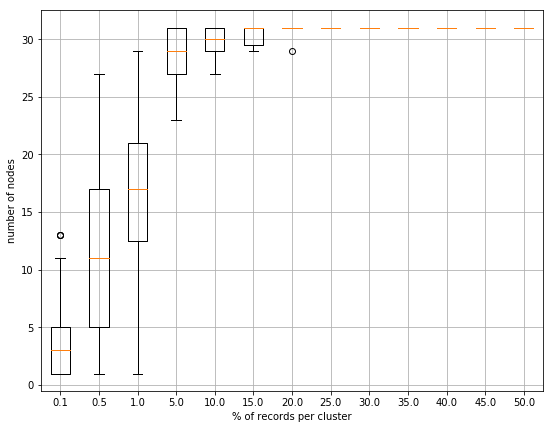

In [15]:
plt.figure(figsize=(9,7))
plt.boxplot(n_counts)
locs, _ = plt.xticks()
plt.xticks(locs, representativity)
#plt.yscale('log')
plt.xlabel('% of records per cluster')
plt.ylabel('number of nodes')
#plt.ylabel('number of nodes (log scale)')
plt.grid()
plt.show()
plt.close()